In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from graphviz import Source
from IPython.display import SVG
import os
import warnings
warnings.filterwarnings('ignore')

Voor een beter weergave voor functies zoals `describe()` van pandas.

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)
pd.set_option('precision', 2)

Dataset inladen. Alle kolommen gemarkeerd als 'nvt' of '?' worden er uit gegooid.

# Data preperation

Alle kolommen die in de data-dictionary als '?' of 'nvt' werden beschreven, hebben wij gedropt.

In [3]:
df_full = pd.DataFrame()
df_full = pd.read_csv("data/sap_storing_data_hu_project.csv", low_memory=False)

nvt_columns = ["stm_sap_mon_meld_ddt", "stm_mon_begin_ddt", "stm_mon_toelichting_trdl",  "stm_oh_pg_mld",  "stm_geo_mld_uit_functiepl",  "stm_scenario_mon",  "stm_status_melding_sap",  "stm_mon_nr_status_omschr",  "stm_mon_nr__statuscode",  "stm_mon_nr_status_wijzdd",  "stm_aanntpl_ddt",  "stm_geo_gst_uit_functiepl",  "stm_objectdl_code_gst",  "stm_objectdl_groep_gst",  "stm_progfh_in_ddt",  "stm_progfh_in_invoer_ddt",  "stm_progfh_gw_ddt",  "stm_progfh_gw_lwd_ddt",  "stm_progfh_hz", "stm_veroorz_groep", "stm_veroorz_code", "stm_veroorz_tekst_kort", "stm_effect", "stm_afspr_aanvangddt", "stm_mon_eind_ddt", "stm_mon_vhdsincident", "stm_dir_betrok_tr", "stm_aangelegd_dd", "stm_aangelegd_tijd", "stm_mon_begindatum", "stm_mon_begintijd", "stm_progfh_gw_datum", "stm_mon_eind_datum", "stm_mon_eind_tijd", "stm_controle_dd", "stm_akkoord_mon_toewijz", "stm_status_sapnaarmon", "stm_fact_jn", "stm_akkoord_melding_jn", "stm_afsluit_ddt", "stm_afsluit_dd", "stm_afsluit_tijd", "stm_rec_toegev_ddt", "stm_hinderwaarde", "stm_actie", "stm_standplaats", "stm_status_gebr", "stm_wbi_nummer", "stm_projnr", "stm_historie_toelichting", "stm_schade_verhaalb_jn", "stm_schadenr", "stm_schade_status_ga", "stm_schade_statusdatum", "stm_relatiervo_vorig", "stm_relatiervo_volgend", "stm_relatiervo", "stm_afspr_func_hersteldd", "stm_afspr_func_hersteltijd", "stm_sorteerveld", "stm_rapportage_maand", "stm_rapportage_jaar", "stm_x_bron_publ_dt", "stm_x_bron_bestandsnaam", "stm_x_bron_arch_dt", "stm_x_actueel_ind", "stm_x_run_id", "stm_x_bk", "stm_x_start_sessie_dt", "stm_x_vervallen_ind", "stm_evb", "stm_functiepl_mld", "stm_functiepl_gst", "stm_arbeid", "stm_progfh_in_duur", "stm_progfh_gw_lwd_datum", "stm_progfh_gw_lwd_tijd", "stm_progfh_gw_duur", "stm_afspr_aanvangdd", "stm_afspr_aanvangtijd", "stm_reactie_duur"]

for x in nvt_columns:
    df_full.drop(x, axis=1, inplace=True)

## Select data
Kolommen die ons interessant lijken worden geisoleerd in een nieuwe DataFrame.

In [4]:
df = pd.DataFrame()
df = df_full[["stm_sap_meld_ddt",  "stm_geo_mld",  "stm_equipm_nr_mld",  "stm_equipm_soort_mld",  "stm_km_van_mld",  "stm_km_tot_mld",  "stm_prioriteit",  "stm_geo_gst",  "stm_oorz_code",  "stm_tao_indicator",  "stm_tao_indicator_vorige",  "stm_tao_soort_mutatie",  "stm_tao_telling_mutatie",  "stm_tao_beinvloedbaar_indicator",  "stm_sap_melddatum",  "stm_sap_meldtijd",  "stm_contractgeb_mld",  "stm_techn_mld",  "stm_techn_gst",  "stm_aanngeb_dd",  "stm_aanngeb_tijd",  "stm_aanntpl_dd",  "stm_aanntpl_tijd", "stm_sap_storeinddatum", "stm_sap_storeindtijd", 'stm_fh_tijd', 'stm_fh_duur']]
df.drop_duplicates(keep='last', inplace=True)

## Data construction
De tijd kolommen worden verdeeld in stukken van een half uur zodat we tijd als categorische data kunnen gebruiken omdat deze als kwantitatieve data niet goed bruikbaar is.

In [5]:
df['stm_sap_meldtijd'] = pd.to_datetime(df['stm_sap_meldtijd'], errors='coerce')
df['stm_sap_meldtijd'] = df['stm_sap_meldtijd'].dt.floor('30T')

### Herbruikbare functies

Returned voor een gegeven kolom uit de dataset de gemiddelde functie herstel duur per uniek waarde van die kolom in een nieuwe dataframe. 

In [6]:
def GetAverageRepairTime(column):
    ret = pd.DataFrame()
    ret = df[['stm_fh_duur', column]][df['stm_fh_duur'].between(1, 360)]
    
    ret.dropna(inplace=True)
    ret.reset_index(inplace=True)
    del ret['index']

    ret = ret.groupby(column, as_index=False)['stm_fh_duur'].mean()
    ret.rename(columns={'stm_fh_duur': 'stm_fh_duur_avg'}, inplace=True)

    ret.set_index(column, inplace=True)

    return ret

Returned voor een gegeven dataframe alle kolomen terug als dummies in een nieuwe dataframe.

In [7]:
def GetDummiesAllColumns(df):
    ret = pd.DataFrame()
    ret = df
    for column in ret.columns:
        ret = ret.join(pd.get_dummies(ret[column], prefix=column))
        del ret[column]
    return ret

# Modelling
## Baseline

Voor de baseline pakken we de gemmidelde hersteltijd per techniek veld (`stm_techn_mld`), en kijken we hoe ver dat gemmideld van de daadwerkelijke hersteltijd afzit.

Enkel de waardes tussen 1 en 360 minuten (6 uur) worden gepakt. De eerder beschreven GetAverageRepairTime functie word gebruikt om de gemmideldes te halen per techniekveld, deze worden toegevoegd aan de rijen zodat we kunnen kijken hoe ver deze van de daadwerklijke hersteltijd liggen.

In [8]:
df_bl = pd.DataFrame()
df_bl = df[['stm_fh_duur', 'stm_techn_mld']][df['stm_fh_duur'].between(1, 360)]

df_bl = pd.merge(   df_bl, 
                    GetAverageRepairTime('stm_techn_mld'), 
                    left_on='stm_techn_mld', right_on='stm_techn_mld')

In [24]:
df_bl.head()

,stm_fh_duur,stm_techn_mld,stm_fh_duur_avg
0,7.000000,S,106.194947
1,20.000000,S,106.194947
2,5.000000,S,106.194947
3,1.000000,S,106.194947
4,10.000000,S,106.194947


Deze voorspelling resulteerd in een gemmidelde squared error van 80 minuten.

In [28]:
print("Baseline MAE  :",mean_absolute_error(df_bl['stm_fh_duur_avg'], df_bl['stm_fh_duur']))
print("Baseline RMSE :",sqrt(mean_squared_error(df_bl['stm_fh_duur_avg'], df_bl['stm_fh_duur'])))

Baseline MAE  : 63.102447517872285
Baseline RMSE : 80.69133143381941


# Linear Regression

We doen een poging tot betere waardes krijgen door een voorspelling met lineaire regressie te doen. We pakken hiervoor het techniekveld, en de meldtijd van de storing. Wederom alleen de waardes tussen 1 en 360 minuten. 

In [69]:
df_lr = pd.DataFrame()
df_lr = df[['stm_fh_duur', 'stm_techn_mld', 'stm_sap_meldtijd', 'stm_prioriteit']][df['stm_fh_duur'].between(1, 360)]

df_lr.dropna(inplace=True)

We gebruiken dummy variabelen om kwalitatieve waardes in het regressie modelw

In [70]:
X_lr = df_lr.loc[:, df_lr.columns != 'stm_fh_duur']
y_lr = df_lr['stm_fh_duur']

X_lr = GetDummiesAllColumns(X_lr)

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=0)

In [71]:
linreg = LinearRegression()

linreg.fit(X_train_lr, y_train_lr)

y_pred_lr = linreg.predict(X_test_lr)

print("Linear Regression REA:",mean_absolute_error(y_test_lr, y_pred_lr))
print("Linear Regression RMSE:",np.sqrt(mean_squared_error(y_test_lr, y_pred_lr)))

Linear Regression REA: 59.94417912121623
Linear Regression RMSE: 77.5681169120473


# Regression Tree

We gaan kijken of een regression tree beter scored.

In [13]:
df_rt = pd.DataFrame()
df_rt = df[['stm_geo_mld', 'stm_techn_mld', 'stm_prioriteit', 'stm_sap_meldtijd', 'stm_fh_duur']][df['stm_fh_duur'].between(1, 360)]
df_rt.dropna(inplace=True)

Er word weer gebruik gemaakt van dummies.

In [14]:
X_rt = df_rt.loc[:, df_rt.columns != 'stm_fh_duur']
y_rt = df_rt['stm_fh_duur']

X_rt = GetDummiesAllColumns(X_rt)

X_train_rt, X_test_rt, y_train_rt, y_test_rt = train_test_split(X_rt, y_rt, random_state=0)

In [67]:
regtree = DecisionTreeRegressor(criterion='mse',  min_samples_leaf=100,max_leaf_nodes=150)

regtree = regtree.fit(X_train_rt, y_train_rt)

y_pred_rt = regtree.predict(X_test_rt)

print("Regression Tree REA :", mean_absolute_error(y_test_rt, y_pred_rt))
print("Regression Tree RMSE :", np.sqrt(mean_squared_error(y_test_rt, y_pred_rt)))

Regression Tree REA : 58.12738992811377
Regression Tree RMSE : 75.95937236252911


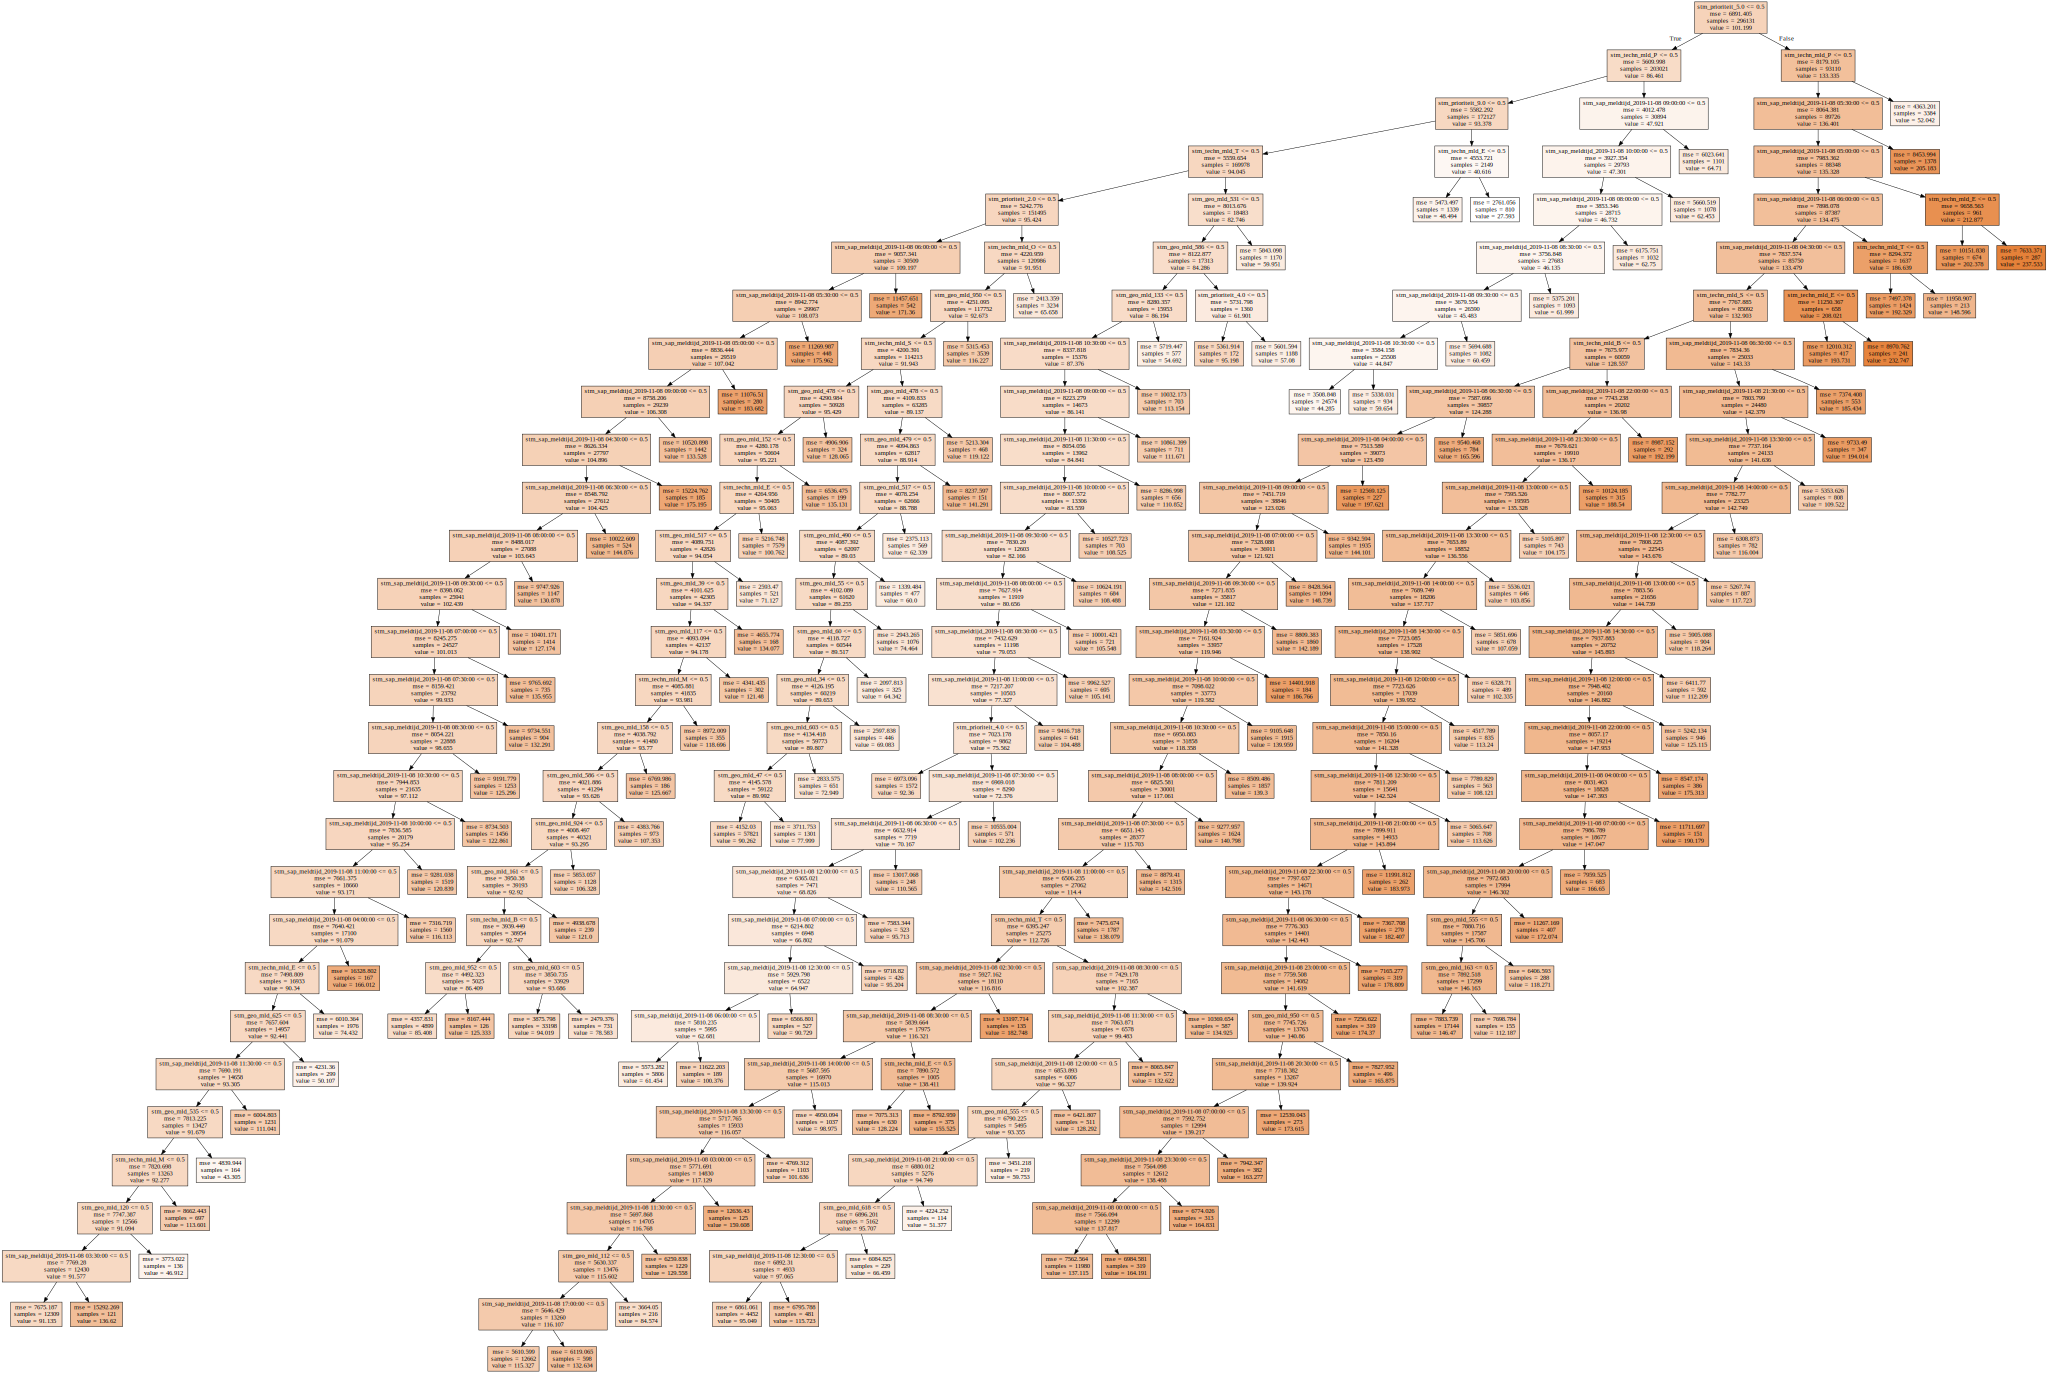

In [68]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

graph = Source( tree.export_graphviz(regtree, out_file=None, feature_names=X_rt.columns,filled=True))

from IPython.core.display import display, HTML
display(HTML('<style>svg{width:50%!important;height:50%!important;}</style>'))
SVG(graph.pipe(format='svg'))

# Validatie

Functie die de verwachte `stm_fh_duur` voor een gegeven dataset voorspeld. Heeft ook de getrainde regressiontree nodig als input, en de testset zodat de dummies overeenkomen.

In [59]:
def GetPredictions(regressionTree, trainSet, inputDF):
    X = pd.DataFrame()
    desiredcols = ['stm_geo_mld', 'stm_techn_mld', 'stm_prioriteit', 'stm_sap_meldtijd']
    
    X = inputDF[desiredcols]

    X['stm_sap_meldtijd'] = pd.to_datetime(X['stm_sap_meldtijd'], errors='coerce')
    X['stm_sap_meldtijd'] = X['stm_sap_meldtijd'].dt.floor('30T')

    X = GetDummiesAllColumns(X)
    
    missing_cols = set(trainSet.columns) - set(X.columns)
    for c in missing_cols:
        X[c] = 0
    X = X[trainSet.columns]

    return regressionTree.predict(X)

In [60]:
df_validatie = pd.DataFrame()
df_validatie = pd.read_csv("data/Validatieset Excel - met targetvariabelen V2.csv", delimiter=';')

In [61]:
predictions = GetPredictions(regtree, X_train_rt, df_validatie)
predictions

array([ 94.64769024,  90.00184853, 116.22718282, 145.58601631,
        94.64769024,  39.45230263, 117.75653135,  72.94930876,
       194.01440922, 188.53968254, 165.69180328, 165.69180328,
       182.74814815, 118.26438053,  85.40804246,  74.46375465,
       142.51558935, 140.79802956, 182.74814815, 145.58601631,
        90.00184853,  59.65417559, 142.51558935,  90.00184853,
       137.7741038 , 128.22380952, 145.58601631,  85.40804246,
       138.07946279, 124.57810578,  94.64769024,  82.97204301,
        72.94930876,  88.71037087,  65.65769944, 132.63377926,
        90.00184853,  72.94930876, 117.75653135,  90.00184853,
       105.54785021, 145.58601631,  59.95128205,  90.00184853,
       108.48830409,  60.45933457, 120.83936801, 113.15362731,
       127.34541063,  59.95128205, 120.20014937, 108.16455696,
       124.26498801, 110.85213415, 145.58601631, 110.85213415,
        90.00184853,  85.40804246, 117.75653135,  90.00184853,
        90.00184853,  71.98790544,  57.80613961,  88.71

In [62]:
MAE = mean_absolute_error(df_validatie['stm_fh_duur'],predictions)
RMSE = sqrt(mean_squared_error(df_validatie['stm_fh_duur'],predictions))

print("Validatie resultaten:")
print("MEA :",MAE)
print("RMSE:",RMSE)

Validatie resultaten:
MEA : 67.04060973963117
RMSE: 86.55860559819017
